In [1]:
# are the future functions actually necessary?
from __future__ import absolute_import, division, print_function, unicode_literals
import imp

from data_read import read_paths
from pathData import PathData
from snapData import SnapData
from datasetData import DatasetData
from plotData import PlotData
from importanceData import ImportanceData
from globalConstants import Const
from autoEncoder import AutoEncoder 
from stepwiseData import StepwiseData
from gridData import GridData
#from data_plot import map_generated

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import random
import time

np.set_printoptions(precision=3, suppress=True)
# allows for automatic reloading of imports and makes it unncessecary to restart the kernel
# whenever a function is changed
%load_ext autoreload
%autoreload 2

In [2]:
c = Const()
c.folder_name = "RPE_org"

#used_vars = [0, 1, 7, 8, 9]
#used_vars = [0, 1, 7, 8, 9, 10, 11, 13, 3]
#used_vars = [0, 2, 5, 6, 7, 8, 9, 11, 13, 17, 18, 19, 20, 21]
used_vars = [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 
    12, 13, 14, 15, 16, 17, 18, 19, 20, 21
    ]
var_names = c.used_names(used_vars)
var_order = c.used_order(used_vars)
print(var_names)
print(var_order)


{0: 'MCG', 1: 'N_{w,4}', 2: 'N_{w,3}', 3: 'N_{w,2}', 4: 'N_{sw,3-4}', 5: 'N_{sw,2-3}', 6: 'F4', 7: 'R_g', 8: '5^{12}6^{2}', 9: '5^{12}', 10: 'CR', 11: 'N_{s,2}', 12: 'N_{s,3}', 13: 'N_{c,2}', 14: 'N_{c,3}', 15: 'N_{s,4}', 16: 'N_{c,4}', 17: '5^{12}6^{3}', 18: '5^{12}6^{4}', 19: '4^{1}5^{10}6^{2}', 20: '4^{1}5^{10}6^{3}', 21: '4^{1}5^{10}6^{4}'}
[0, 11, 12, 15, 13, 14, 16, 3, 2, 1, 5, 4, 9, 8, 17, 18, 19, 20, 21, 10, 7, 6]


In [3]:
pathO = PathData(
    *read_paths(
        c.folder_name, 
        c.mcg_A, 
        c.mcg_B,
        used_vars,
        c.used_frac), 
    c.path_type_labels, 
    c.path_type_weights)

mcg100
Total paths: 552	 Used paths: 110
mcg70
Total paths: 699	 Used paths: 139
mcg30
Total paths: 2776	 Used paths: 555
mcg80
Total paths: 539	 Used paths: 107
mcg35
Total paths: 1288	 Used paths: 257
mcg90
Total paths: 292	 Used paths: 58
mcg50
Total paths: 2838	 Used paths: 567
mcg60
Total paths: 1090	 Used paths: 218
mcg40
Total paths: 1652	 Used paths: 330
mcg45
Total paths: 2130	 Used paths: 426
Sum weights: 2767.0
Mean weights: 1.0


In [4]:
snapO = SnapData(
    *pathO.snapshots_labels_weights(
        offset = c.offset, 
        progress = c.progress, 
        transitioned = c.transitioned, 
        turnedback = c.turnedback))

Mean weights: 1.0
Sum weights AA: 1348628.0	 Sum weights AB: 30291.0
Sum weights AA after: 689459.4999969611	 Sum weights AB after: 689459.49999961


In [5]:
dataO = DatasetData(
    *snapO.split_lists(c.train_ratio, c.val_ratio), 
    outlier_cutoff = c.outlier_cutoff)

In [6]:
gridO = GridData(c.resolution)


In [21]:
train_grid_past_snapshots = gridO.gridify_snapshots(dataO.train_norm_past_snapshots, \
    dataO.minima, dataO.maxima)
#train_grid_snapshots = train_grid_past_snapshots
val_grid_past_snapshots = gridO.gridify_snapshots(dataO.val_norm_past_snapshots, \
    dataO.minima, dataO.maxima)
#val_grid_snapshots = val_grid_past_snapshots
inv_res = 2.0 / (c.resolution - 1.0)


Get normed
Get bounded
Got bounded
Got normed


In [23]:
inv_res = 2.0 / (c.resolution - 1.0)
val_grid_past_snapshots * inv_res - 1

array([[ 0.286,  0.286,  0.143, ...,  1.   ,  1.   , -1.   ],
       [ 0.   , -0.143,  0.   , ..., -1.   ,  1.   , -1.   ],
       [-0.857, -0.857, -0.857, ..., -1.   , -1.   , -1.   ],
       ...,
       [-0.571, -0.857, -0.714, ..., -1.   , -1.   , -1.   ],
       [-0.143, -0.286, -0.286, ..., -1.   , -1.   , -1.   ],
       [-0.286, -0.429, -0.429, ...,  1.   , -1.   , -1.   ]])

In [10]:
train_grid_past_columns = np.transpose(train_grid_past_snapshots)

In [28]:
pB_dict, pBs = gridO.approximate_pB(train_grid_snapshots, dataO.train_snapshot_labels, dataO.train_snapshot_weights)

Fill hash maps
Rescale


In [29]:
print(len(pB_dict)/len(pBs))
print(np.mean([label for key, label in pB_dict.items()]))
print(np.mean(pBs))
print(len([label for key, label in pB_dict.items() if label == 0])/len(pBs))

0.7099103040910085
0.01509474521470344
0.03986356674897464
0.698991117433834


0.02118452552573287
0.031373568874645076
0.7666105437716277


In [24]:
#print([*zip([(key, label) for key, label in pB_dict.items()])])
#print([key for key, label in pB_dict.items()])
#print([label for key, label in pB_dict.items()])
trimmed_keys = list(map(list,[list(map(lambda x: float(x)/(c.resolution-1), key)) for key, label in pB_dict.items() if label > 0.0 and label < 1.0]))
trimmed_labels = [label for key, label in pB_dict.items() if label > 0.0 and label < 1.0]
trimmed_back_keys = list(map(list,[list(map(lambda x: float(x)/(c.resolution-1), key)) for key, label in pB_dict.items() if label < 1.0]))
trimmed_back_labels = [label for key, label in pB_dict.items() if label < 1.0]
print(len(trimmed_keys))
print(len(trimmed_back_keys))

#print(trimmed_keys[:10])
#print(trimmed_labels[:10])

2362
636761


In [84]:
gridO.plot_distribution(train_grid_snapshots,6,20,var_names,"untrimmed")
gridO.plot_distribution(trimmed_keys,6,20,var_names,"trimmed_both")
gridO.plot_distribution(trimmed_back_keys,6,20,var_names,"trimmed_back")

648832
1.0
0.0
12684
636148
636169
12663


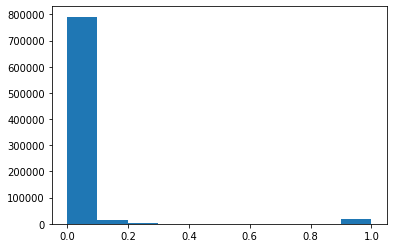

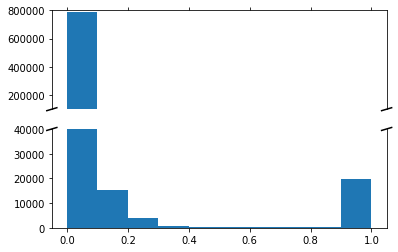

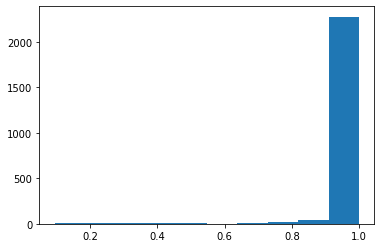

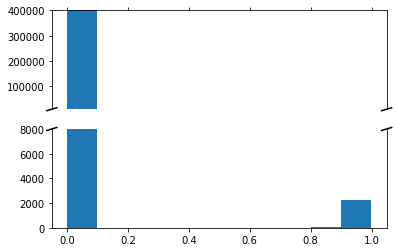

In [85]:
print(len(pB_dict))
print(max([label for key, label in pB_dict.items()]))
print(min([label for key, label in pB_dict.items()]))
print(len([label for key, label in pB_dict.items() if label > 0.0]))
print(len([label for key, label in pB_dict.items() if label == 0.0]))
print(len([label for key, label in pB_dict.items() if label < 0.25]))
print(len([label for key, label in pB_dict.items() if label > 0.25]))

def broken_hist(xs, bins, y_lower_1, y_upper_1, y_lower_2, y_upper_2, filename):
    f, (ax, ax2) = plt.subplots(2, 1, sharex=True)
    # ax.hist([label for key, label in pB_dict.items()], 100)
    # ax2.hist([label for key, label in pB_dict.items()], 100)
    ax.hist(xs, bins)
    ax2.hist(xs, bins)
    ax.set_ylim(y_lower_2, y_upper_2)  # outliers only
    ax2.set_ylim(y_lower_1, y_upper_1)  # most of the data
    # hide the spines between ax and ax2
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()

    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
    plt.savefig(filename)
    plt.show()
    

plt.figure()
plt.hist(pBs, 10)
plt.savefig("pB_untrimmed.png")
plt.show()

broken_hist(pBs, 10, 0, 40000, 100000, 800000, "pBs.png")

plt.figure()
plt.hist(trimmed_labels, 10)
plt.savefig("trimmed_labels.png")
plt.show()
    
broken_hist(trimmed_back_labels, 10, 0, 8000, 10000, 400000, "Hist_scaled_labels.png")


In [86]:
for i in range(1,11):
    #print(len([ele for ele in pBs if (ele >= (i-1)*0.1 and ele < i*0.1)]))
    print(len([ele for ele in pBs if (ele >= (i-1)*0.1 and ele < i*0.1)])*i*0.1)


    


79120.1
3043.6000000000004
1192.5
215.60000000000002
124.0
165.60000000000002
140.0
204.0
338.40000000000003
6006.0


In [34]:
# generates the dataset by feeding in a tuple, of dictionaries 
# (alternative would be a tuble of lists)
#train_grid_ds = tf.data.Dataset.from_tensor_slices(
#    ({c.input_name: trimmed_back_keys}, 
#    {c.output_name_1: trimmed_back_labels, 
#    c.output_name_2: trimmed_back_keys})) \
#        .shuffle(snapO.snapshot_cnt) \
#        .batch(c.batch_size)
#print("train_ds generated")
train_grid_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: trimmed_keys}, 
    {c.output_name_1: trimmed_labels, 
    c.output_name_2: trimmed_keys})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
print("train_ds generated")
val_grid_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: val_grid_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_labels, 
    c.output_name_2: val_grid_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_weights, 
    c.output_name_2: dataO.val_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
print("val_ds generated")

train_ds generated
val_ds generated


In [35]:
# generates the dataset by feeding in a tuple, of dictionaries 
# (alternative would be a tuble of lists)
"""
train_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: dataO.train_norm_past_snapshots}, 
    {c.output_name_1: dataO.train_snapshot_labels, 
    c.output_name_2: dataO.train_norm_snapshots}, 
    {c.output_name_1: dataO.train_snapshot_weights, 
    c.output_name_2: dataO.train_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
print("train_ds generated")
val_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: dataO.val_norm_past_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_labels, 
    c.output_name_2: dataO.val_norm_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_weights, 
    c.output_name_2: dataO.val_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
print("val_ds generated")
"""
pass

In [36]:
modelO = AutoEncoder(c)
(autoencoder, autoencoder_1, autoencoder_2) = \
    modelO.model(dataO.dimensions)

In [37]:
#autoencoder.fit(train_ds_batch,epochs=EPOCHS, class_weight=class_weight)
history = autoencoder.fit(
    train_grid_ds,epochs = c.epochs,  
    validation_data = val_grid_ds)
#history = autoencoder.fit(
#    train_ds,epochs = c.epochs,  
#    validation_data = val_ds)

Train for 222 steps, validate for 1871 steps
Epoch 1/5
222/222 [==============================] - 5s 24ms/step - loss: 0.5716 - label_loss: 0.4239 - reconstruction_loss: 0.1477 - val_loss: 1.1384 - val_label_loss: 1.0044 - val_reconstruction_loss: 0.1340
Epoch 2/5
222/222 [==============================] - 4s 17ms/step - loss: 0.5450 - label_loss: 0.4196 - reconstruction_loss: 0.1255 - val_loss: 1.1130 - val_label_loss: 0.9816 - val_reconstruction_loss: 0.1314
Epoch 3/5
222/222 [==============================] - 4s 18ms/step - loss: 0.5350 - label_loss: 0.4149 - reconstruction_loss: 0.1200 - val_loss: 1.0809 - val_label_loss: 0.9564 - val_reconstruction_loss: 0.1246
Epoch 4/5
222/222 [==============================] - 4s 19ms/step - loss: 0.5280 - label_loss: 0.4108 - reconstruction_loss: 0.1172 - val_loss: 1.0876 - val_label_loss: 0.9608 - val_reconstruction_loss: 0.1268
Epoch 5/5
222/222 [==============================] - 4s 17ms/step - loss: 0.5252 - label_loss: 0.4094 - reconstruct

In [38]:
print(history.history["val_loss"][-1])

0.9223387407339046


In [39]:
#plotO = PlotData(*dataO.plot_data(), c.stamp)
#plotO = PlotData(
#    np.zeros(len(used_vars)), 
#    [c.resolution-1]*len(used_vars),
#    trimmed_back_keys, 
#    trimmed_back_labels, 
#    np.ones(len(trimmed_back_keys)), 
#    c.stamp)
plotO = PlotData(
    np.zeros(len(used_vars)), 
    np.ones(len(used_vars)),
    trimmed_keys, 
    trimmed_labels, 
    np.ones(len(trimmed_keys)), 
    c.stamp)

1: N_{s,2}	0: MCG
2: N_{s,3}	0: MCG
2: N_{s,3}	1: N_{s,2}
3: N_{s,4}	0: MCG
3: N_{s,4}	1: N_{s,2}
3: N_{s,4}	2: N_{s,3}
4: N_{c,2}	0: MCG
4: N_{c,2}	1: N_{s,2}
4: N_{c,2}	2: N_{s,3}
4: N_{c,2}	3: N_{s,4}
5: N_{c,3}	0: MCG
5: N_{c,3}	1: N_{s,2}
5: N_{c,3}	2: N_{s,3}
5: N_{c,3}	3: N_{s,4}
5: N_{c,3}	4: N_{c,2}
6: N_{c,4}	0: MCG
6: N_{c,4}	1: N_{s,2}
6: N_{c,4}	2: N_{s,3}
6: N_{c,4}	3: N_{s,4}
6: N_{c,4}	4: N_{c,2}
6: N_{c,4}	5: N_{c,3}
7: N_{w,2}	0: MCG
7: N_{w,2}	1: N_{s,2}
7: N_{w,2}	2: N_{s,3}
7: N_{w,2}	3: N_{s,4}
7: N_{w,2}	4: N_{c,2}
7: N_{w,2}	5: N_{c,3}
7: N_{w,2}	6: N_{c,4}
8: N_{w,3}	0: MCG
8: N_{w,3}	1: N_{s,2}
8: N_{w,3}	2: N_{s,3}
8: N_{w,3}	3: N_{s,4}
8: N_{w,3}	4: N_{c,2}
8: N_{w,3}	5: N_{c,3}
8: N_{w,3}	6: N_{c,4}
8: N_{w,3}	7: N_{w,2}
9: N_{w,4}	0: MCG
9: N_{w,4}	1: N_{s,2}
9: N_{w,4}	2: N_{s,3}
9: N_{w,4}	3: N_{s,4}
9: N_{w,4}	4: N_{c,2}
9: N_{w,4}	5: N_{c,3}
9: N_{w,4}	6: N_{c,4}
9: N_{w,4}	7: N_{w,2}
9: N_{w,4}	8: N_{w,3}
10: N_{sw,2-3}	0: MCG
10: N_{sw,2-3}	1: N_{s,2

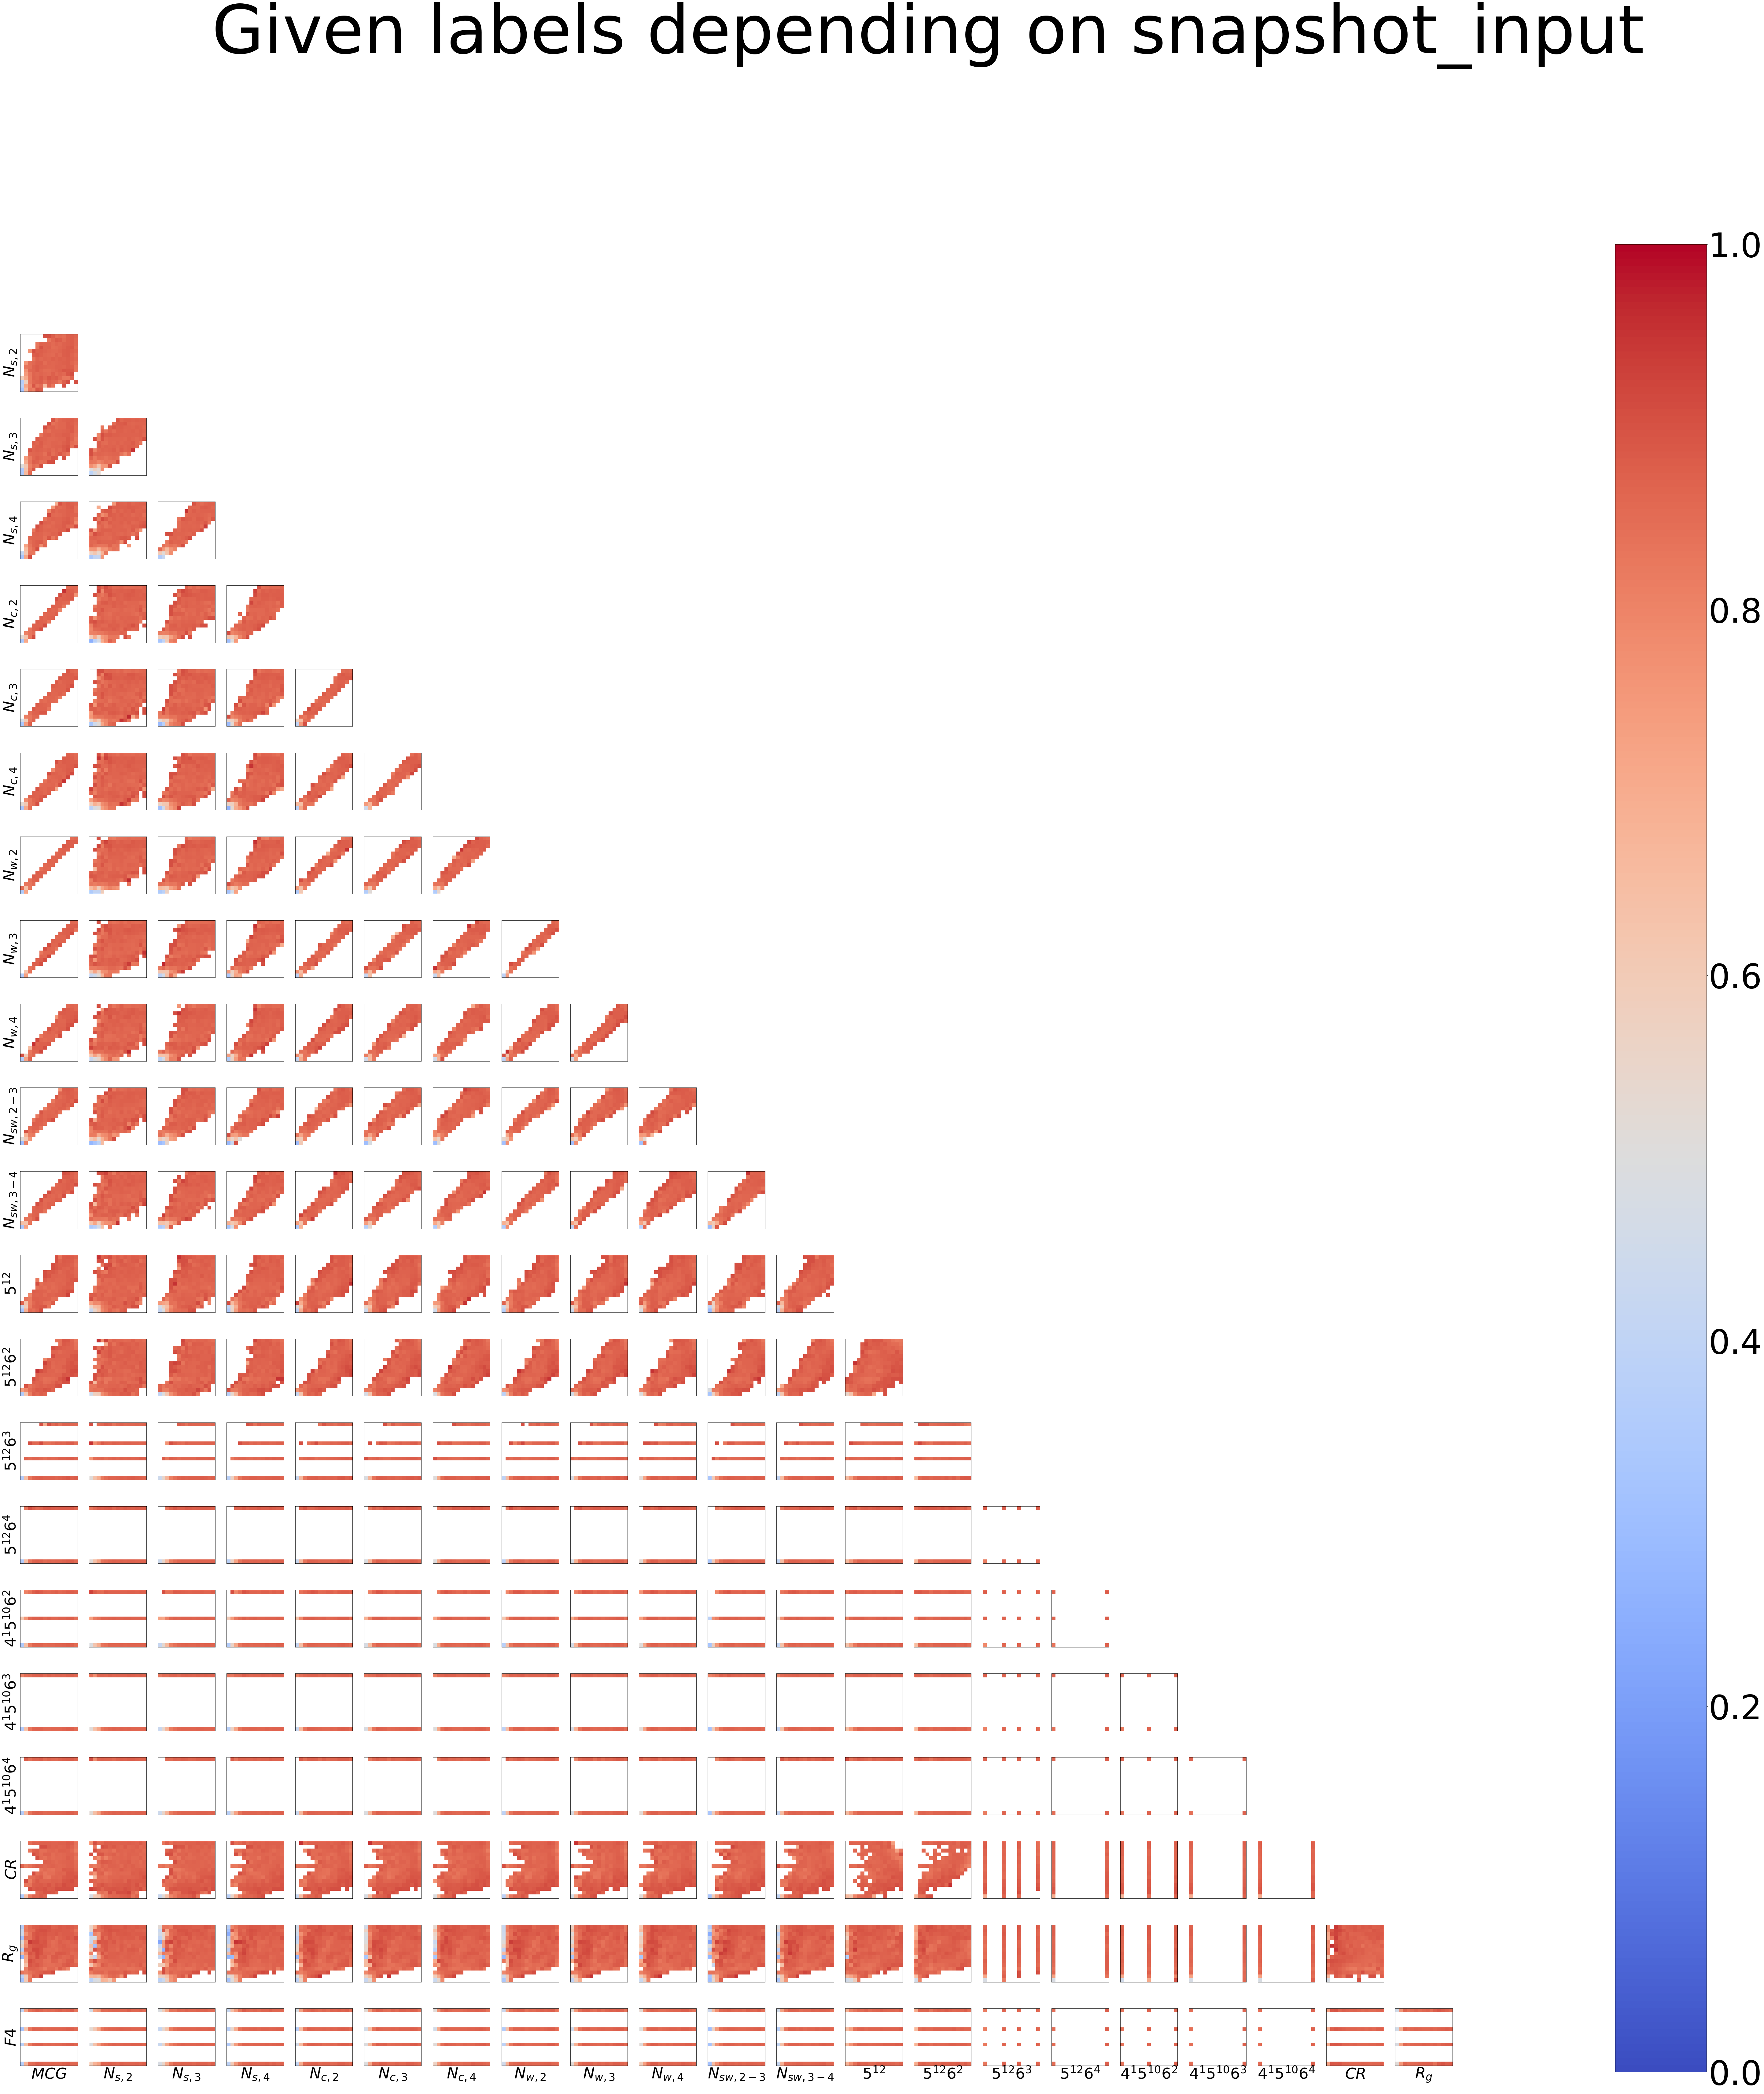

In [46]:
#var_names = c.used_names([0, 1, 7, 8, 9])
#var_order = c.used_order([0, 1, 7, 8, 9])

plotO.plot_super_map(
    subfig_size = c.subfig_size, 
    i_s = var_order, js = var_order, 
    stamp = c.stamp, var_names = var_names, 
    resolution = c.resolution,
    vmin = c.min_label, vmax = c.max_label, model = None, fill_val = 0)
        

pass

1: N_{s,2}	0: MCG
2: N_{s,3}	0: MCG
2: N_{s,3}	1: N_{s,2}
3: N_{s,4}	0: MCG
3: N_{s,4}	1: N_{s,2}
3: N_{s,4}	2: N_{s,3}
4: N_{c,2}	0: MCG
4: N_{c,2}	1: N_{s,2}
4: N_{c,2}	2: N_{s,3}
4: N_{c,2}	3: N_{s,4}
5: N_{c,3}	0: MCG
5: N_{c,3}	1: N_{s,2}
5: N_{c,3}	2: N_{s,3}
5: N_{c,3}	3: N_{s,4}
5: N_{c,3}	4: N_{c,2}
6: N_{c,4}	0: MCG
6: N_{c,4}	1: N_{s,2}
6: N_{c,4}	2: N_{s,3}
6: N_{c,4}	3: N_{s,4}
6: N_{c,4}	4: N_{c,2}
6: N_{c,4}	5: N_{c,3}
7: N_{w,2}	0: MCG
7: N_{w,2}	1: N_{s,2}
7: N_{w,2}	2: N_{s,3}
7: N_{w,2}	3: N_{s,4}
7: N_{w,2}	4: N_{c,2}
7: N_{w,2}	5: N_{c,3}
7: N_{w,2}	6: N_{c,4}
8: N_{w,3}	0: MCG
8: N_{w,3}	1: N_{s,2}
8: N_{w,3}	2: N_{s,3}
8: N_{w,3}	3: N_{s,4}
8: N_{w,3}	4: N_{c,2}
8: N_{w,3}	5: N_{c,3}
8: N_{w,3}	6: N_{c,4}
8: N_{w,3}	7: N_{w,2}
9: N_{w,4}	0: MCG
9: N_{w,4}	1: N_{s,2}
9: N_{w,4}	2: N_{s,3}
9: N_{w,4}	3: N_{s,4}
9: N_{w,4}	4: N_{c,2}
9: N_{w,4}	5: N_{c,3}
9: N_{w,4}	6: N_{c,4}
9: N_{w,4}	7: N_{w,2}
9: N_{w,4}	8: N_{w,3}
10: N_{sw,2-3}	0: MCG
10: N_{sw,2-3}	1: N_{s,2

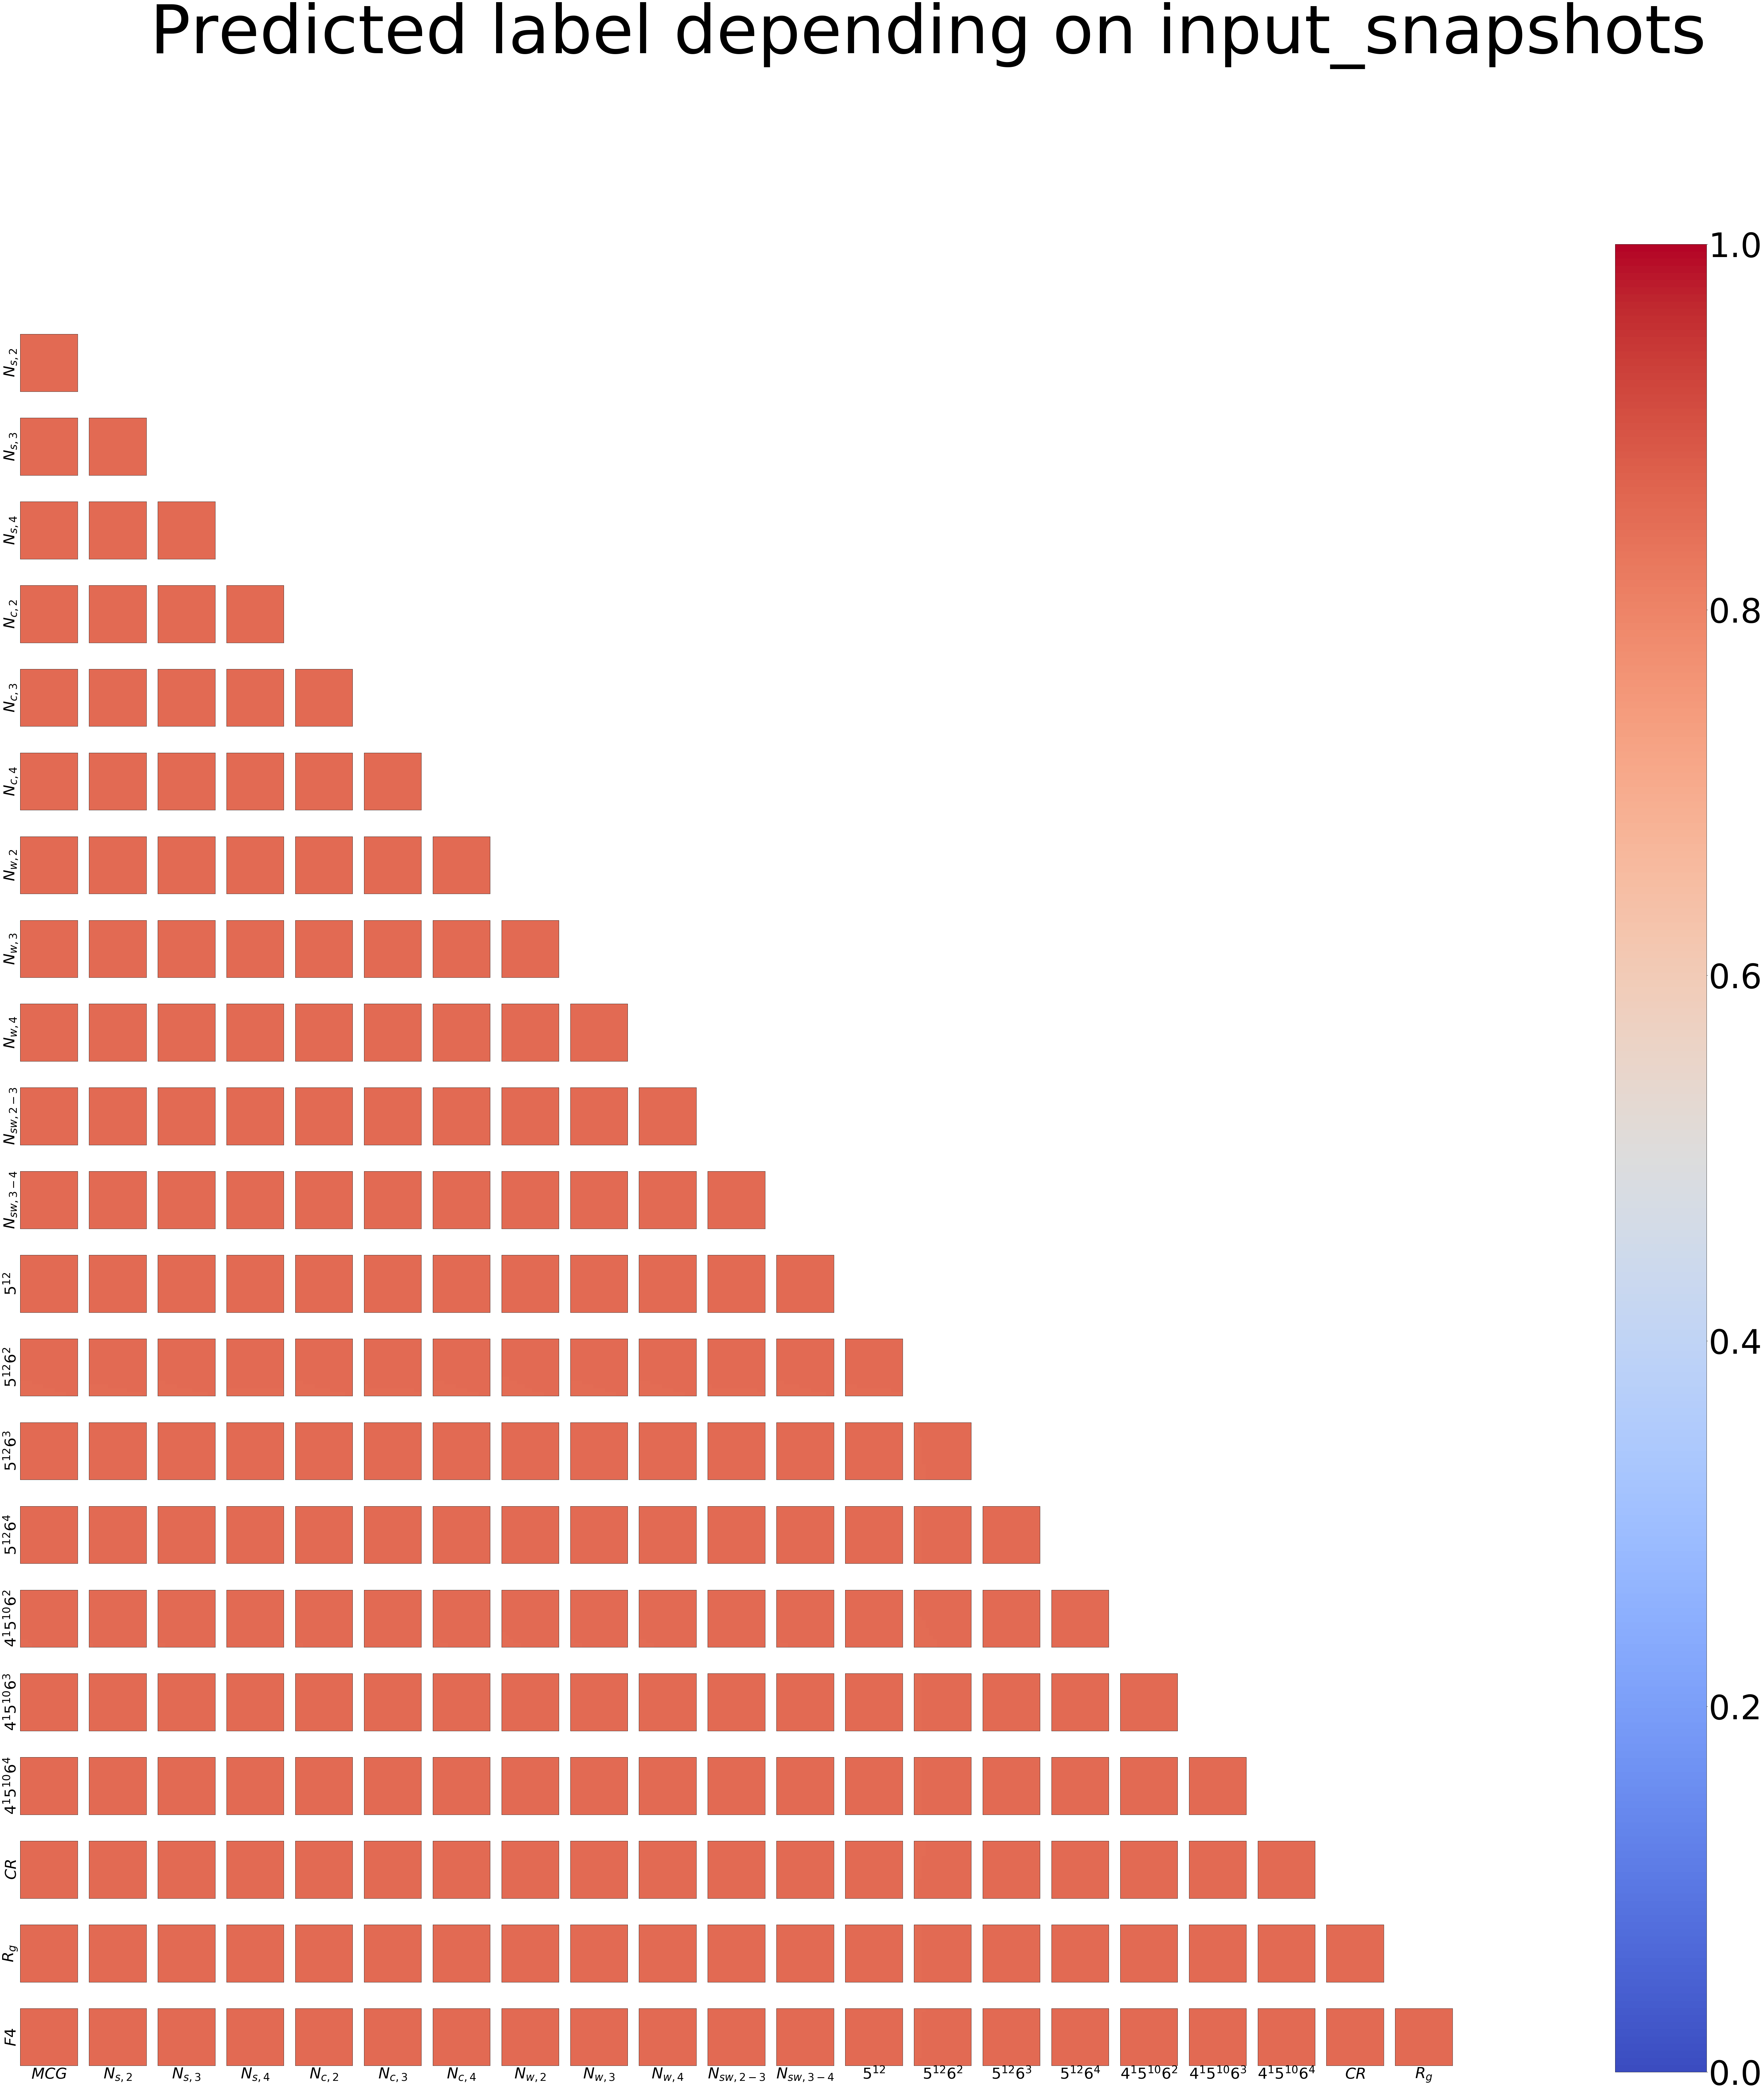

In [47]:
plotO.plot_super_map(
    subfig_size = c.subfig_size, 
    i_s = var_order, js = var_order, 
    stamp = c.stamp, var_names = var_names, 
    resolution = c.resolution, 
    vmin = c.min_label, vmax = c.max_label, 
    model = autoencoder_1, fill_val = 0.5)
pass

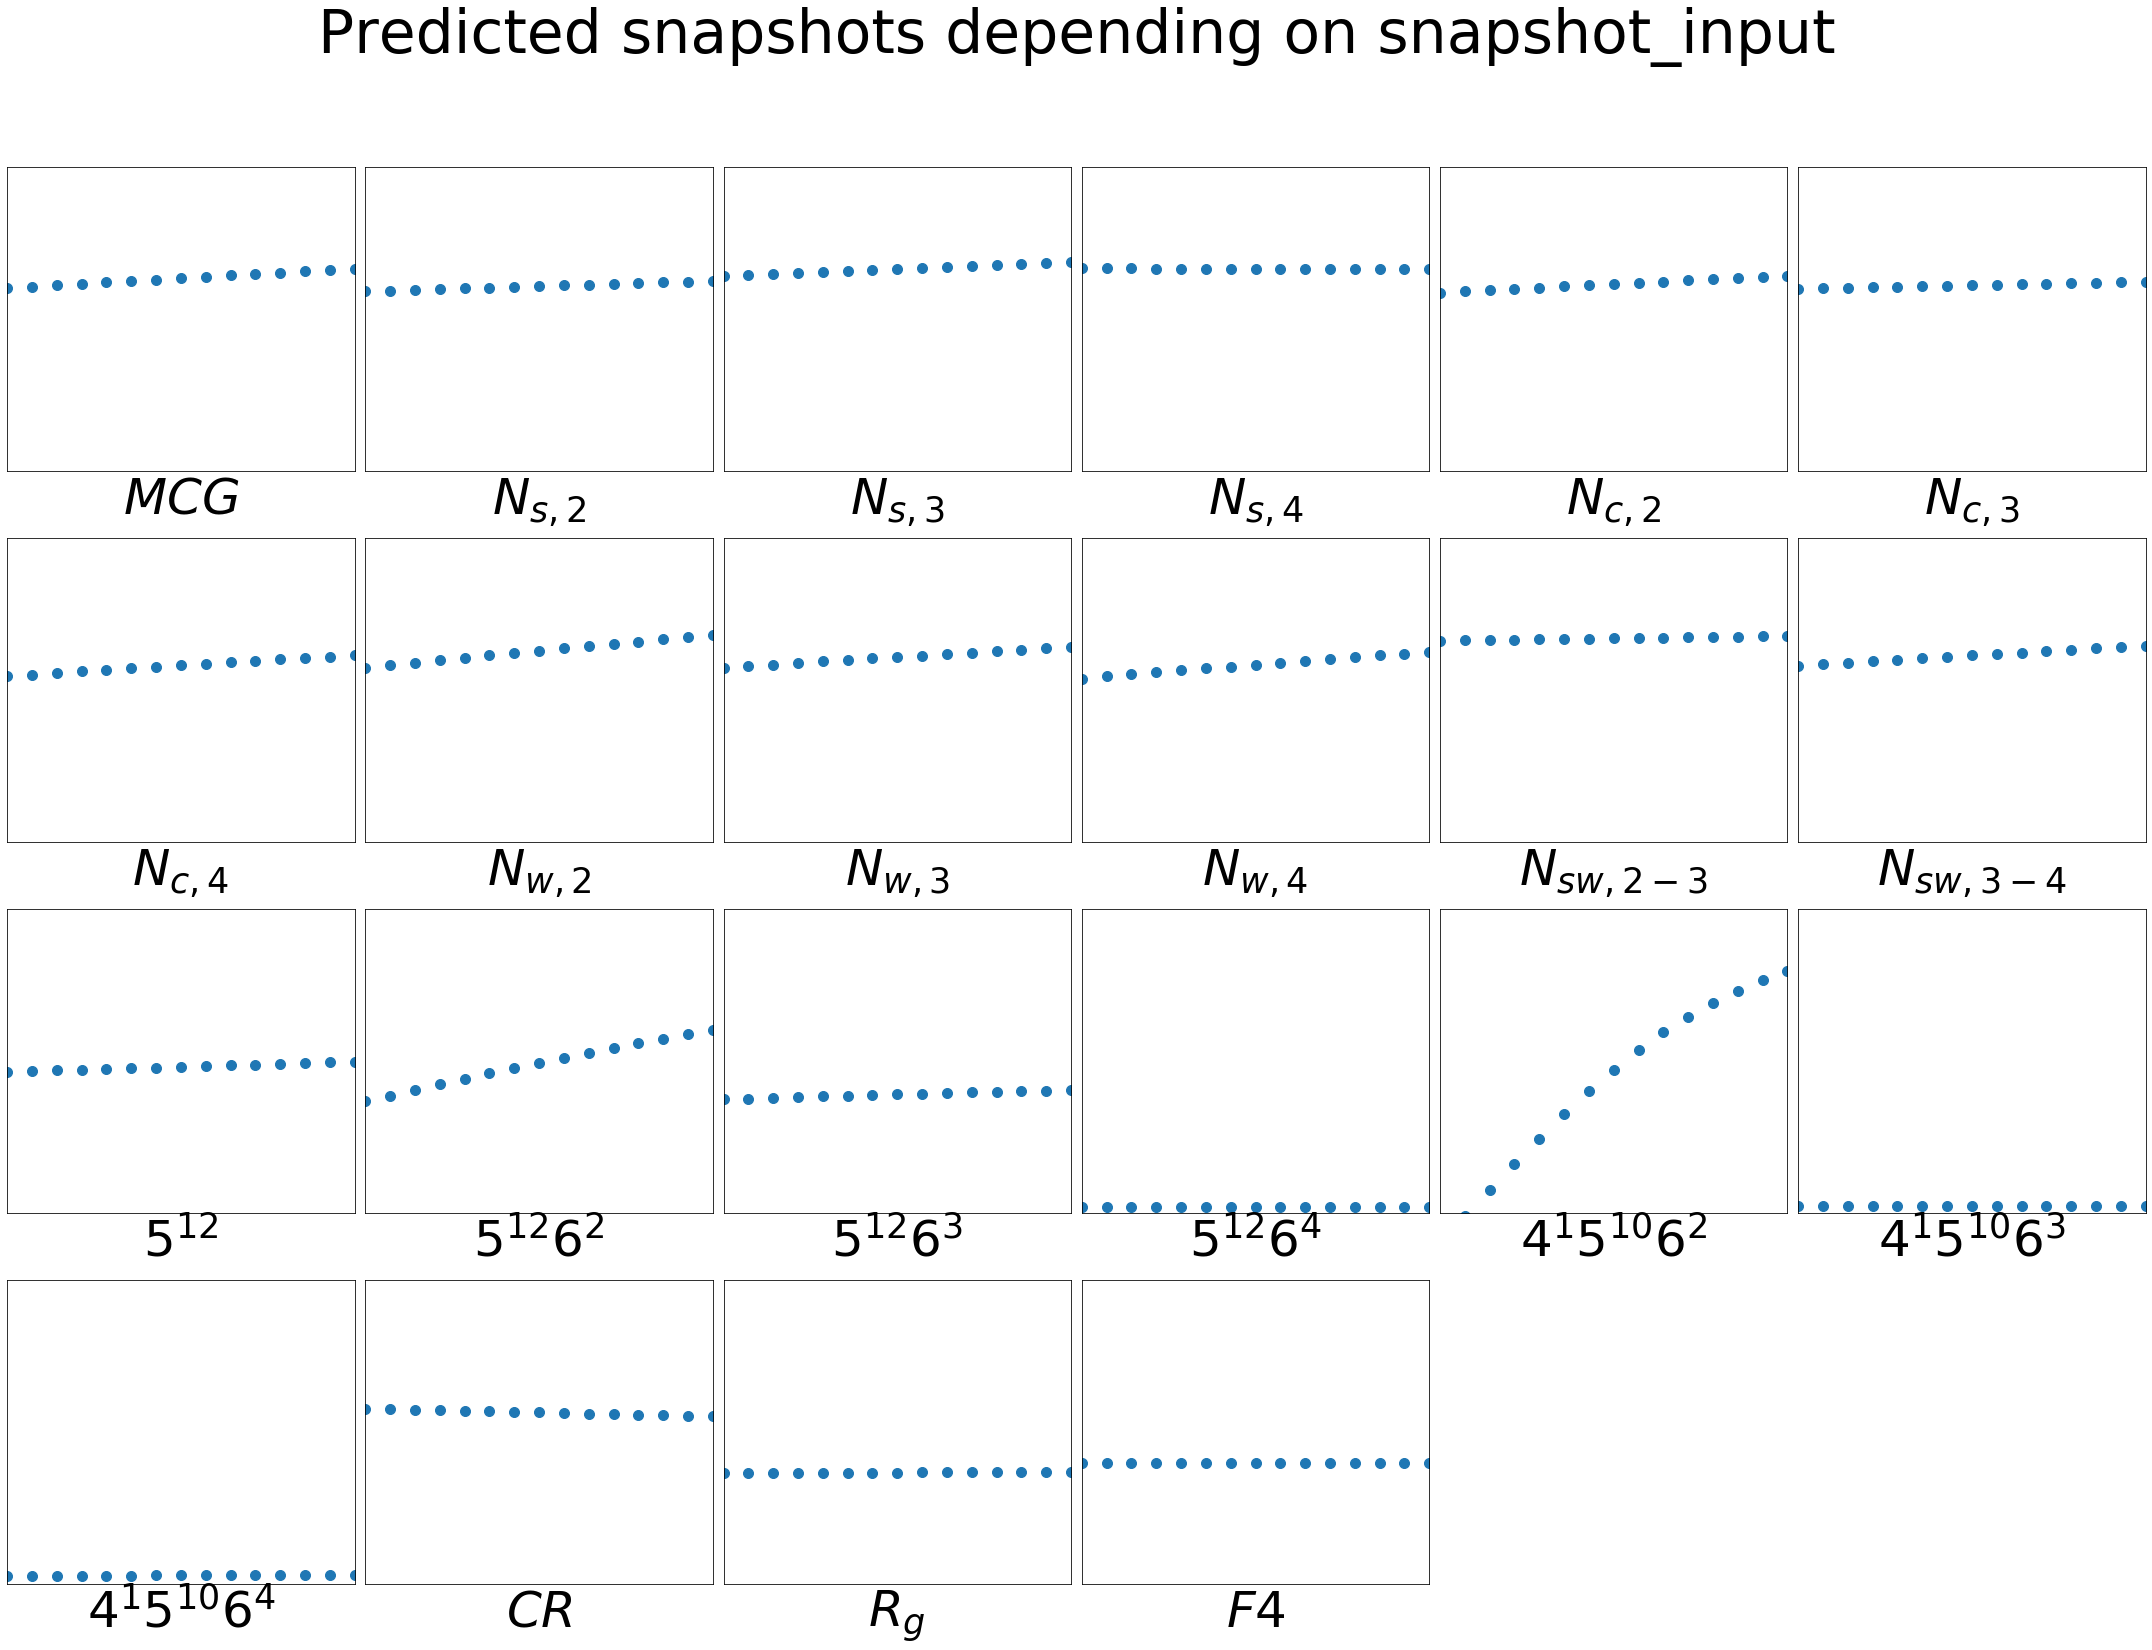

In [48]:
plotO.plot_super_scatter(
    subfig_size = c.subfig_size, i_s = var_order, 
    stamp = c.stamp, var_names = var_names, 
    resolution = c.resolution, model = autoencoder_2, 
    max_row_len = 6, fill_val = 0.5)

In [85]:
stepO = StepwiseData(*dataO.stepwise_data())

KeyboardInterrupt: 

In [ ]:
used, loss = stepO.bottom_up(
    used = [], 
    unused = used_vars, 
    param_limit = 8, 
    epochs = 2, 
    repetitions = 3, 
    const = c)

[0]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.40180739760398865
[1]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.40675100684165955
[2]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.40220752358436584
[3]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.40430858731269836
[4]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.4179173409938812
[5]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.4201720058917999
[6]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.6937370300292969
[7]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.5862486958503723
[8]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.3981379270553589
[9]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.47743502259254456
[10]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.5020818114280701
[11]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean loss: 0.5060977935791016
[12]
 Repetition 1
 Repetition 2
 Repetition 3
  Mean los

In [ ]:
print(used, loss)

In [ ]:
used, loss = stepO.top_down( 
    used = used_vars,
    unused = [],
    param_limit = 8, 
    epochs = 2, 
    repetitions = 3, 
    const = c)

In [ ]:
print(used, loss)

In [15]:
impO = ImportanceData(
    *dataO.importance_data(),
    c.corr_thresholds)

impO.measure_correlation()
pass

Caution!
Correlation between input data can affect the reliability of the importance measure.
Strong correlations of more than 0.5 were found between 41 pair(s) of input variables:
	1,0: 1.009
	2,0: 0.997
	2,1: 0.991
	4,0: 0.575
	4,1: 0.571
	4,2: 0.564
	5,0: 0.979
	5,1: 0.984
	5,2: 0.965
	5,4: 0.573
	6,0: 0.977
	6,1: 0.978
	6,2: 0.962
	6,4: 0.530
	6,5: 0.924
	7,0: 0.813
	7,1: 0.799
	7,2: 0.812
	7,5: 0.762
	7,6: 0.767
	8,0: 1.008
	8,1: 1.008
	8,2: 0.994
	8,4: 0.572
	8,5: 0.980
	8,6: 0.978
	8,7: 0.776
	9,0: 0.824
	9,1: 0.826
	9,2: 0.817
	9,5: 0.746
	9,6: 0.846
	9,7: 0.637
	9,8: 0.826
	10,6: 0.516
	11,0: 0.545
	11,1: 0.546
	11,2: 0.536
	11,5: 0.518
	11,6: 0.508
	11,8: 0.543
Additionally, weak correlations of more than 0.1 were found between 37 pair(s) of input variables:
	7,4: 0.486
	9,4: 0.407
	10,0: 0.439
	10,1: 0.438
	10,2: 0.437
	10,4: 0.156
	10,5: 0.340
	10,7: 0.333
	10,8: 0.441
	10,9: 0.415
	11,4: 0.318
	11,7: 0.453
	11,9: 0.462
	11,10: 0.225
	12,0: 0.391
	12,1: 0.393
	12,2: 0.387
	

val_ds generated
Mode: Mean
Repetition 1.
	Perturbing variable 0.
	Perturbing variable 7.
	Perturbing variable 8.
	Perturbing variable 1.
	Perturbing variable 2.
	Perturbing variable 6.
	Perturbing variable 5.
	Perturbing variable 9.
	Perturbing variable 10.
	Perturbing variable 11.
	Perturbing variable 12.
	Perturbing variable 13.
	Perturbing variable 4.
	Perturbing variable 3.
Mode: HIPR
Repetition 1.
	Perturbing variable 0.
	Perturbing variable 7.
	Perturbing variable 8.
	Perturbing variable 1.
	Perturbing variable 2.
	Perturbing variable 6.
	Perturbing variable 5.
	Perturbing variable 9.
	Perturbing variable 10.
	Perturbing variable 11.
	Perturbing variable 12.
	Perturbing variable 13.
	Perturbing variable 4.
	Perturbing variable 3.
Mode: Shuffle
Repetition 1.
	Perturbing variable 0.
	Perturbing variable 7.
	Perturbing variable 8.
	Perturbing variable 1.
	Perturbing variable 2.
	Perturbing variable 6.
	Perturbing variable 5.
	Perturbing variable 9.
	Perturbing variable 10.
	Perturb

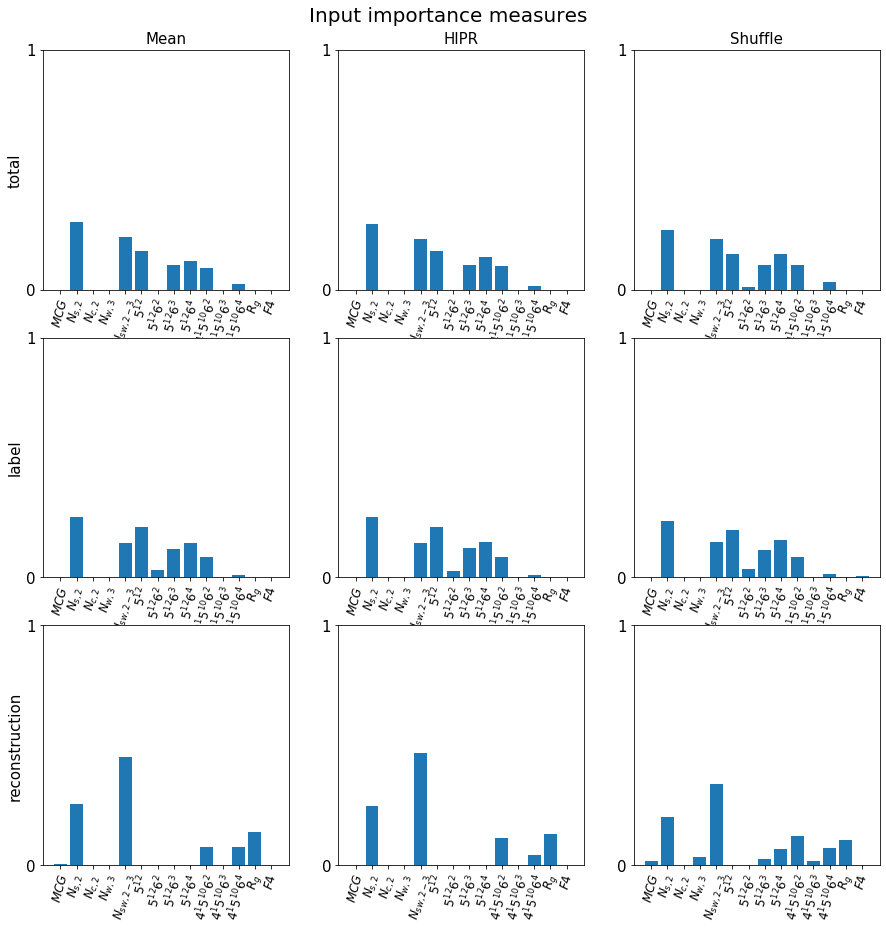

In [16]:
val_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: dataO.val_norm_past_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_labels, 
    c.output_name_2: dataO.val_norm_snapshots}, 
    {c.output_name_1: dataO.val_snapshot_weights, 
    c.output_name_2: dataO.val_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
print("val_ds generated")

modes = [["Mean", None],["HIPR", [-0.9,0.9]],["Shuffle", None]]
#modes = [["Perturb", 0.5]]

impO.plot_super_importance(
    subfig_size = c.subfig_size, i_s = var_order, 
    stamp = c.stamp, var_names = var_names, 
    repetitions = 1, modes = modes,
    loss_names = c.loss_names,
    val_ds = val_ds, model = autoencoder)


In [17]:
test_ds = tf.data.Dataset.from_tensor_slices(
    ({c.input_name: dataO.test_norm_past_snapshots}, 
    {c.output_name_1: dataO.test_snapshot_labels, 
    c.output_name_2: dataO.test_norm_snapshots}, 
    {c.output_name_1: dataO.test_snapshot_weights, 
    c.output_name_2: dataO.test_snapshot_weights})) \
        .shuffle(snapO.snapshot_cnt) \
        .batch(c.batch_size)
print("test_ds generated")

test_ds generated


In [14]:
impO.reduced_set_importance([1], [2,3,4,5,6], "a", 1)

('will be set later', 'will be set later')

In [25]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(a)
t = np.transpose(a)
print(t)
n = []
for i in [0,2]:
    n.append(t[i])

print(np.transpose(n))
print(np.transpose([t[0],t[2]]))

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[1 4 7]
 [2 5 8]
 [3 6 9]]
[[1 3]
 [4 6]
 [7 9]]
[[1 3]
 [4 6]
 [7 9]]


In [17]:
model = autoencoder
print(model.name)
print(model.input_names)
print(model.output_names)

Autoencoder
['input_snapshots']
['label', 'reconstruction']


In [11]:
def show_batch(dataset):
    for batch, label, weights in dataset.take(1):
        for key, value in batch.items():
            print("{:20s}: {}".format(key,value.numpy()))

In [ ]:
#past, present = data.offset_path_lists(5)
#print(past[0][:10])
#print(present[0][:5])
#print(data.path_list[0])
#print(data.label_list[2])
#print(data.mc_weight_list[2])
#AA_past_snapshot_list, AB_past_snapshot_list, \
#    BA_past_snapshot_list, BB_past_snapshot_list, \
#    AA_snapshot_list, AB_snapshot_list, \
#    BA_snapshot_list, BB_snapshot_list, \
#    AA_snapshot_label_list, AB_snapshot_label_list, \
#    BA_snapshot_label_list, BB_snapshot_label_list, \
#    AA_snapshot_weight_list, AB_snapshot_weight_list, \
#    BA_snapshot_weight_list, BB_snapshot_weight_list = paths.snapshot_label_weight_lists(0,True,True,True)

In [3]:
#setter c.used_vars
bce = tf.keras.losses.BinaryCrossentropy()
bce = tf.keras.losses.CategoricalCrossentropy()
bce = tf.keras.losses.CategoricalHinge()
loss = bce([1.], [0.])
#print('Loss: ', loss.numpy())  # Loss: 11.522857
def neg_likelihood(y_actual, y_pred):
#    return -(y_actual*math.log(y_pred) + (1-y_actual)*math.log(1-y_pred))
    #print(y_actual*math.log(y_pred), (1-y_actual)*math.log(1-y_pred))
    # tf.math.log()
    return -(y_actual * tf.math.log(y_pred) + (1-y_actual) * tf.math.log(1-y_pred))
#print(likelihood_max_loss(1., 0.9999))
loss = neg_likelihood(tf.constant([1.,1.]), tf.constant([0.000000000001,0.9]))
print('Loss: ', loss.numpy())  # Loss: 11.522857

Loss:  [27.631  0.105]


In [11]:
train_grid_columns = np.transpose(train_grid_snapshots)
def rec_cols(used, unused, lim, p):
    if len(used) == lim:
        p.append(used)
        return
    else:
        for i in range(len(unused)):
            rec_cols(used+[unused[i]], unused[i+1:], lim, p)

def mean_pB_attributes(dimensions, train_grid_columns, dataO, tries):
    p = []
    rec_cols([],list(range(22)),dimensions, p)
    pB_uniques = []
    pB_unique_means = []
    pB_means = []
    pB_unique_zeroes = []
    for i in range(tries):
        choice = random.choice(p)
        short_grid_snapshots = []
        for j in choice:
            short_grid_snapshots.append(train_grid_columns[j])

        pB_dict, pBs = gridO.approximate_pB(np.transpose(short_grid_snapshots), dataO.train_snapshot_labels, dataO.train_snapshot_weights)
        pB_uniques.append(len(pB_dict)/len(pBs))
        pB_unique_means.append(np.mean([label for key, label in pB_dict.items()]))
        pB_means.append(np.mean(pBs))
        pB_unique_zeroes.append(len([label for key, label in pB_dict.items() if label == 0])/len(pBs))
    return np.mean(pB_uniques), np.mean(pB_unique_means), np.mean(pB_means), np.mean(pB_unique_zeroes)
over_list = []
for i in range(1,23):
    print(i)
    over_list.append(list(mean_pB_attributes(i, train_grid_columns, dataO, 5)))

print(over_list)

1
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
2
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
3
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
4
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
5
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
6
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
7
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
8
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
Rescale
9
Fill hash maps
Rescale
Fill hash maps
Rescale
Fill hash maps
R

In [26]:
over_list = [[1.4504122192394765e-05, 0.4575422359289151, 0.35037916491845283, 0.0], 
             [8.823341000373481e-05, 0.31197805032254855, 0.24989161958688205, 1.4987592932141258e-05], 
             [0.0011390570628427355, 0.254336987822713, 0.21065742919045424, 0.00041312574711337754], 
             [0.0031104090041590574, 0.18133452313340712, 0.2170178744045542, 0.0019471784043289969], 
             [0.019666622751407806, 0.14815356079849162, 0.1799223783174298, 0.016739932628352418], 
             [0.03723860852286394, 0.0766339470321534, 0.15529480428303702, 0.03335392112900087], 
             [0.10585688540897394, 0.04434703300207507, 0.12188629749425983, 0.10030736652279384], 
             [0.14584233293970758, 0.03858060089555661, 0.12155443609723238, 0.13996139486143125], 
             [0.2389070660457291, 0.030955704907381622, 0.08891275517831804, 0.2316479946238054], 
             [0.3461106592002669, 0.02109568034865818, 0.07299244764109925, 0.33821316466650786], 
             [0.40314715278037977, 0.023028707168210764, 0.06465460885978427, 0.3932804819236334], 
             [0.5168345720256579, 0.020024200833715332, 0.055430137658731636, 0.5062564739753744], 
             [0.6097532969682758, 0.01770556773880911, 0.04620075248938048, 0.5986738397608754], 
             [0.649903849756633, 0.019642215099454723, 0.040862941059977745, 0.6368426459870116], 
             [0.648240710411905, 0.018966941544334908, 0.04145155090339449, 0.6356276840180286], 
             [0.694312812820677, 0.019123793821338247, 0.037413562972544265, 0.6808039151460504], 
             [0.7417976167309884, 0.0178504232145612, 0.03518109760382279, 0.7283716342882285], 
             [0.7338169652299931, 0.018954433483644333, 0.035358386024052696, 0.7197073551612314], 
             [0.7123308003495493, 0.01780718726971691, 0.03705239598119732, 0.6994197142446192], 
             [0.7675257538819679, 0.01880599290810691, 0.03314824301337975, 0.7529500780200907], 
             [0.7685473275550522, 0.02063167015576706, 0.032021440958897376, 0.752516404766538], 
             [0.7835114721563158, 0.021141123648464055, 0.031053932448914478, 0.766812392805472]
            ]

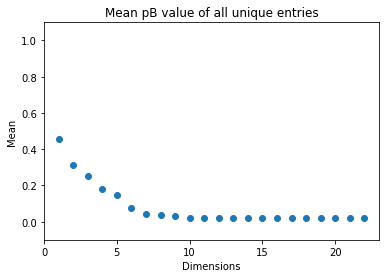

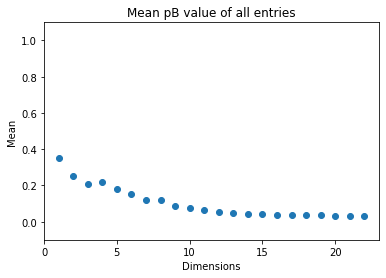

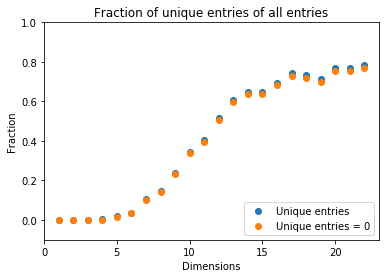

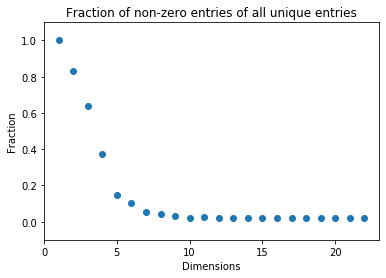

In [27]:
over_columns = np.transpose(over_list)
plt.scatter(list(range(1,23)),over_columns[1])
plt.ylim(-0.1,1.1)
plt.xlim(0,23)
plt.xlabel("Dimensions")
plt.ylabel("Mean")
plt.title("Mean pB value of all unique entries")
plt.show()
plt.close()
            
over_columns = np.transpose(over_list)
plt.scatter(list(range(1,23)),over_columns[2])
plt.ylim(-0.1,1.1)
plt.xlim(0,23)
plt.xlabel("Dimensions")
plt.ylabel("Mean")
plt.title("Mean pB value of all entries")
plt.show()
plt.close()
            
plt.figure()
plt.scatter(list(range(1,23)),over_columns[0], label = "Unique entries")
plt.scatter(list(range(1,23)),over_columns[3], label = "Unique entries = 0")
plt.xlabel("Dimensions")
plt.ylabel("Fraction")
plt.ylim(-0.1,1)
plt.xlim(0,23)
plt.legend(loc = "lower right")
plt.title("Fraction of unique entries of all entries")
plt.show()
plt.figure()

plt.scatter(list(range(1,23)),(over_columns[0]-over_columns[3])/over_columns[0])
plt.ylim(-0.1,1.1)
plt.xlim(0,23)
plt.xlabel("Dimensions")
plt.ylabel("Fraction")
plt.title("Fraction of non-zero entries of all unique entries")
plt.show()
plt.close()